In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import root_mean_squared_error
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")
print("Path to dataset files:", path)
df = pd.read_csv(f'{path}/vehicles.csv')
df.head()

Path to dataset files: /home/mathias/.cache/kagglehub/datasets/austinreese/craigslist-carstrucks-data/versions/10


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
df.describe()
og_len = len(df)

In [5]:
df['price'].max()

3736928711

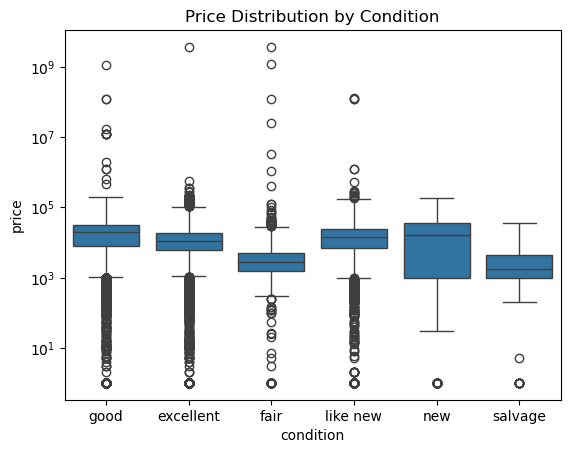

In [6]:
plt.title('Price Distribution by Condition')
plt.yscale('log')
sns.boxplot(data=df, x='condition', y='price')
plt.show()

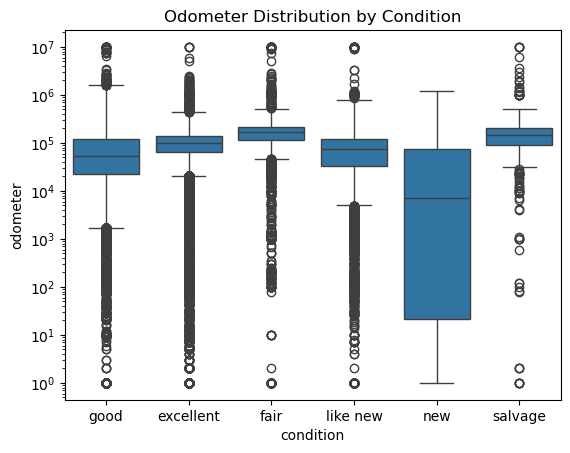

In [7]:
plt.title('Odometer Distribution by Condition')
plt.yscale('log')
sns.boxplot(data=df, x='condition', y='odometer')
plt.show()

In [8]:
df = df[(df['price'] > 1500) & (df['price'] < 100000)]

In [9]:
df[df['odometer'] == 0]['condition'].value_counts()

condition
excellent    431
good          77
fair          20
like new      10
new            7
salvage        3
Name: count, dtype: int64

In [10]:
df = df[(df['odometer'] > 3000) & (df['odometer'] <= 340000)]

In [11]:
df.describe()


,id,price,year,odometer,county,lat,long
count,3.604310e+05,360431.000000,359537.000000,360431.000000,0.0,357196.000000,357196.000000
mean,7.311457e+09,19321.069636,2011.248461,94569.914508,NaN,38.539475,-94.226190
std,4.386013e+06,13982.230317,8.785673,61061.070614,NaN,5.829836,18.062825
min,7.301583e+09,1508.000000,1900.000000,3002.000000,NaN,-81.838232,-159.719900
25%,7.308056e+09,7995.000000,2008.000000,41509.500000,NaN,34.758445,-110.874594
50%,7.312520e+09,15990.000000,2013.000000,89643.000000,NaN,39.260000,-87.980000
75%,7.315232e+09,27990.000000,2017.000000,136162.500000,NaN,42.364188,-80.790000
max,7.317101e+09,99999.000000,2022.000000,340000.000000,NaN,82.390818,167.629911


In [12]:
df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

In [13]:
missing = df.isna().mean() * 100
cols_keep = missing[missing < 5].index.tolist()

if cols_keep:
    df.dropna(subset=cols_keep, inplace=True)

In [14]:
df.isna().mean() * 100

id                0.000000
url               0.000000
region            0.000000
region_url        0.000000
price             0.000000
year              0.000000
manufacturer      0.000000
model             0.000000
condition        37.169743
cylinders        40.824625
fuel              0.000000
odometer          0.000000
title_status      0.000000
transmission      0.000000
VIN              37.318511
drive            29.300671
size             71.584123
type             20.662814
paint_color      27.237755
image_url         0.000000
description       0.000000
county          100.000000
state             0.000000
lat               0.000000
long              0.000000
posting_date      0.000000
dtype: float64

In [15]:
df['year'] = df['year'].astype('int32')

In [16]:
set_remove = ['id', 'url', 'region_url', 'image_url', 'county', 'size']
df.drop(columns=set_remove, inplace=True, errors = "ignore")

Text(0.5, 1.0, 'Top  10 modelos más comunes')

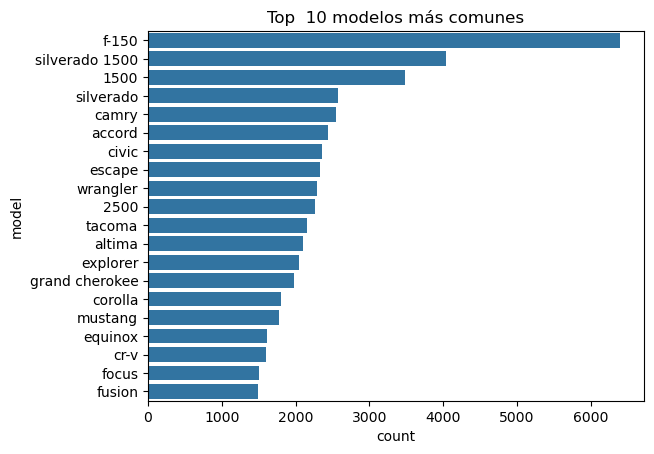

In [17]:
top_model = df['model'].value_counts().head(20).index

sns.countplot(data=df[df['model'].isin(top_model)], y='model', order=top_model)
plt.title('Top  10 modelos más comunes')


Text(0.5, 1.0, 'Top  10 fabricantes más comunes')

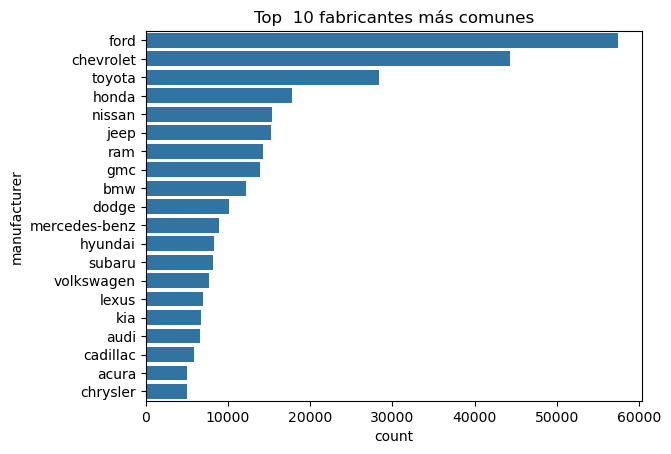

In [18]:
top_model = df['manufacturer'].value_counts().head(20).index

sns.countplot(data=df[df['manufacturer'].isin(top_model)], y='manufacturer', order=top_model)
plt.title('Top  10 fabricantes más comunes')

<Axes: xlabel='condition', ylabel='price'>

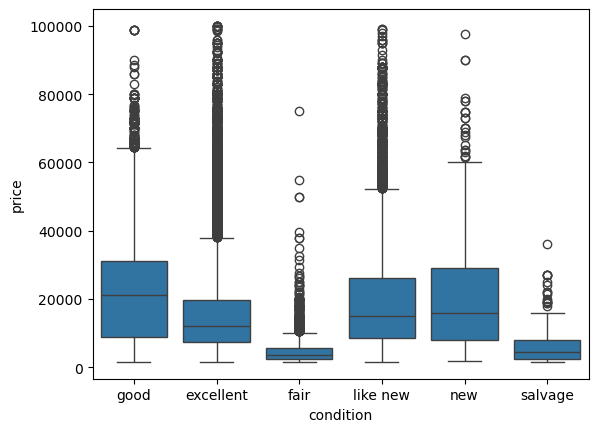

In [19]:
sns.boxplot(data=df, x='condition', y='price')

<Axes: xlabel='condition', ylabel='count'>

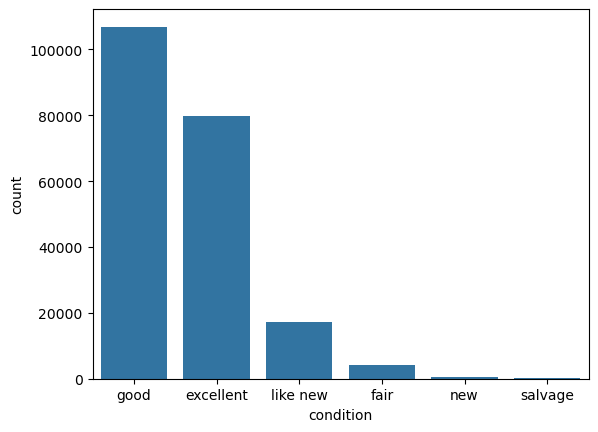

In [20]:
sns.countplot(data = df, x = 'condition', order = df['condition'].value_counts().index)

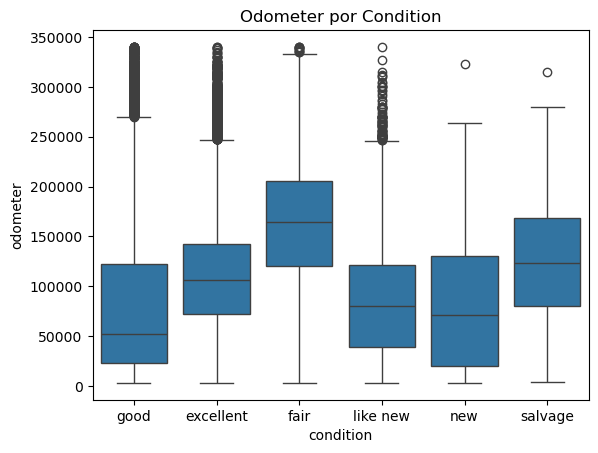

In [21]:
sns.boxplot(data=df, x='condition', y='odometer')
plt.title('Odometer por Condition')
plt.show()


In [22]:
print(f"Se elimino {og_len - len(df)} filas por limpieza de datos. ({((og_len - len(df)) / og_len) * 100:.2f}%)")

Se elimino 94147 filas por limpieza de datos. (22.05%)


In [23]:
def odometer_to_category(x):
    if x <= 20000:
        return 'muy_poco_uso'
    elif x <= 60000:
        return 'poco_uso'
    elif x <= 120000:
        return 'uso_medio'
    elif x <= 200000:
        return 'muy_usado'
    else:
        return 'altisimo_uso'

df['odo_cat'] = df['odometer'].apply(odometer_to_category)

<Axes: xlabel='odo_cat', ylabel='count'>

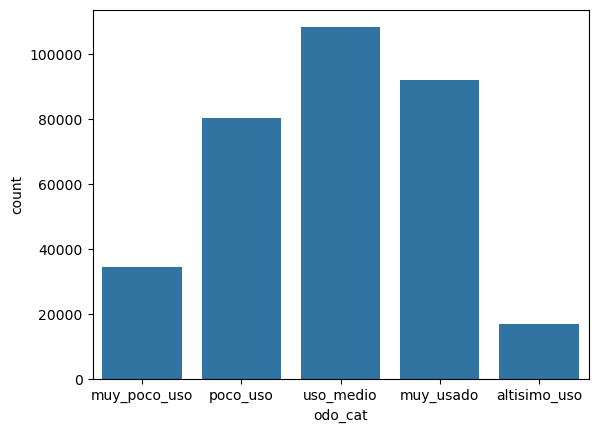

In [24]:
sns.countplot(data=df, x='odo_cat', order=['muy_poco_uso', 'poco_uso', 'uso_medio', 'muy_usado', 'altisimo_uso'])

In [25]:
df.describe()

,price,year,odometer,lat,long
count,332733.000000,332733.000000,332733.000000,332733.000000,332733.000000
mean,19321.575431,2011.561844,94238.924838,38.554881,-94.150317
std,13892.973263,8.153034,60977.374013,5.829482,17.977752
min,1508.000000,1900.000000,3002.000000,-81.838232,-159.719900
25%,7995.000000,2008.000000,41119.000000,34.776390,-110.000000
50%,15995.000000,2013.000000,89392.000000,39.254962,-87.980000
75%,27990.000000,2017.000000,136058.000000,42.398900,-80.790000
max,99999.000000,2022.000000,340000.000000,82.252826,167.629911


In [26]:
# Feature Engineering
df['is_luxury'] = df['manufacturer'].isin(['audi', 'bmw', 'mercedes-benz', 'lexus', 'cadillac', 'infiniti', 'acura', 'jaguar', 'volvo', 'land rover'])

df['age_car'] = 2025 - df['year']
df.loc[df['age_car'] == 0, 'age_car'] = 1
df['km_per_year'] = df['odometer'] / df['age_car']


df['km_per_year'] = df['odometer'] / df['age_car']

mapping_condition = {
    'new': 5,
    'like new': 4,
    'excellent': 3,
    'good': 2,
    'fair': 1,
    'salvage': 0

}

df['condition_score'] = df['condition'].map(mapping_condition)

In [27]:
#not used but mayybe later odo_cat

selected_features = ['year', 'odometer', 'fuel', 'title_status', 'manufacturer', 'model', 'is_luxury', 'age_car', 'km_per_year']

In [28]:
from category_encoders import TargetEncoder


numeric_features = ['year', 'odometer', 'age_car', 'km_per_year']
categorical_features = ['fuel', 'title_status', 'manufacturer', 'model']
binary_features = ['is_luxury']


preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('target', TargetEncoder(), categorical_features),
    ('binary', 'passthrough', binary_features)
])

In [29]:
df['title_status'].value_counts()

title_status
clean         321433
rebuilt         6458
salvage         3244
lien            1251
missing          303
parts only        44
Name: count, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['price'], test_size=0.2, random_state=42)

In [31]:
# Preprocesar SOLO el train
X_train_prep = preprocess.fit_transform(X_train, y_train)

# Preprocesar SOLO el test (para evaluación final)
X_test_prep = preprocess.transform(X_test)


In [32]:
print(np.isnan(X_train_prep).sum())
print(X_train_prep.dtype)

print(np.isinf(X_train_prep).sum())

0
float64
0


In [30]:
def objective(trial):
    classifier_name = trial.suggest_categorical("regressor", ["XGBoost", "RandomForest"])

    if classifier_name == "XGBoost":
         params = {
             "n_estimators": trial.suggest_int("xgb_n_estimators", 100, 600),
             "max_depth": trial.suggest_int("xgb_max_depth", 3, 20),
             "learning_rate": trial.suggest_float("xgb_learning_rate", 0.01, 0.3),
             "min_child_weight": trial.suggest_int("xgb_min_child_weight", 1, 10),
             "subsample": trial.suggest_float("xgb_subsample", 0.5, 1.0),
             "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0),
             "tree_method": "hist",
             #"device": "cpu", 
             "device": "cuda", 
             "eval_metric": "rmse",
             "n_jobs": 1 
         }
         model = XGBRegressor(**params)

    else:
         params = {
             "n_estimators": trial.suggest_int("rf_n_estimators", 100, 600),
             "max_depth": trial.suggest_int("rf_max_depth", 3, 20),
             "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 15),
             "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 10),
             "n_jobs": -1 
         }
         model = RandomForestRegressor(**params)

    score = cross_val_score(
         model,
         X_train_prep,
         y_train,
         scoring="neg_root_mean_squared_error",
         cv=5,
         n_jobs=1 
    ).mean()

    return score

def run_study(study, n_trials):
    for _ in tqdm(range(n_trials)):
        study.optimize(objective, n_trials=1, catch=(Exception,))

study = optuna.create_study(direction="maximize")
run_study(study, n_trials=50)

print(study.best_params)

[I 2025-12-04 08:30:10,537] A new study created in memory with name: no-name-4a429b45-f61e-4d2e-9354-2e2f7339be9f
  0%|          | 0/50 [00:00<?, ?it/s][W 2025-12-04 08:30:20,170] Trial 0 failed with parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 217, 'rf_max_depth': 15, 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_12357/3379684995.py", line 30, in objective
    score = cross_val_score(
            ^^^^^^^^^^^^^^^^
  File "/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/.conda/envs/datasci/lib/python3.12/site

KeyboardInterrupt: 

In [ ]:

fig = plot_optimization_history(study)
fig.show()


In [ ]:
fig = plot_parallel_coordinate(study)
fig.show()

In [ ]:
fig = plot_param_importances(study)
fig.show()

 26%|██▌       | 13/50 [33:58<4:37:44, 450.39s/it][I 2025-12-03 08:42:06,275] Trial 13 finished with value: -3991.08837890625 and parameters: {'n_estimators': 503, 'max_depth': 16, 'learning_rate': 0.024166247470660974, 'min_child_weight': 1, 'subsample': 0.7957819492565436, 'colsample_bytree': 0.7555576891479615}. Best is trial 13 with value: -3991.08837890625.


In [33]:
#best_params = study.best_params

best_params =  {
        "n_estimators": 503,
        "max_depth": 16,
        "learning_rate": 0.02417,
        "min_child_weight": 1,
        "subsample": 0.7958,
        "colsample_bytree": 0.7556,
    }


model = XGBRegressor(
    **best_params,
    tree_method="hist",
    device="cpu"
)

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [34]:
feature_names = preprocess.get_feature_names_out()


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
})

Mean RMSE en el conjunto de prueba: 3981.966796875


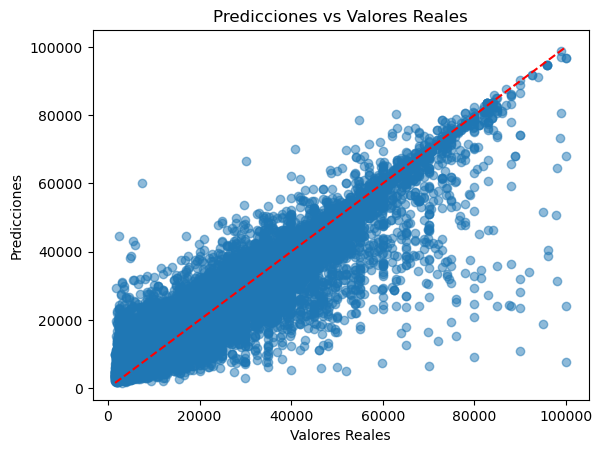

In [35]:
mean_rmse = root_mean_squared_error(y_test, y_pred)
print(f'Mean RMSE en el conjunto de prueba: {mean_rmse}')

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

/tmp/ipykernel_9578/2735879991.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')


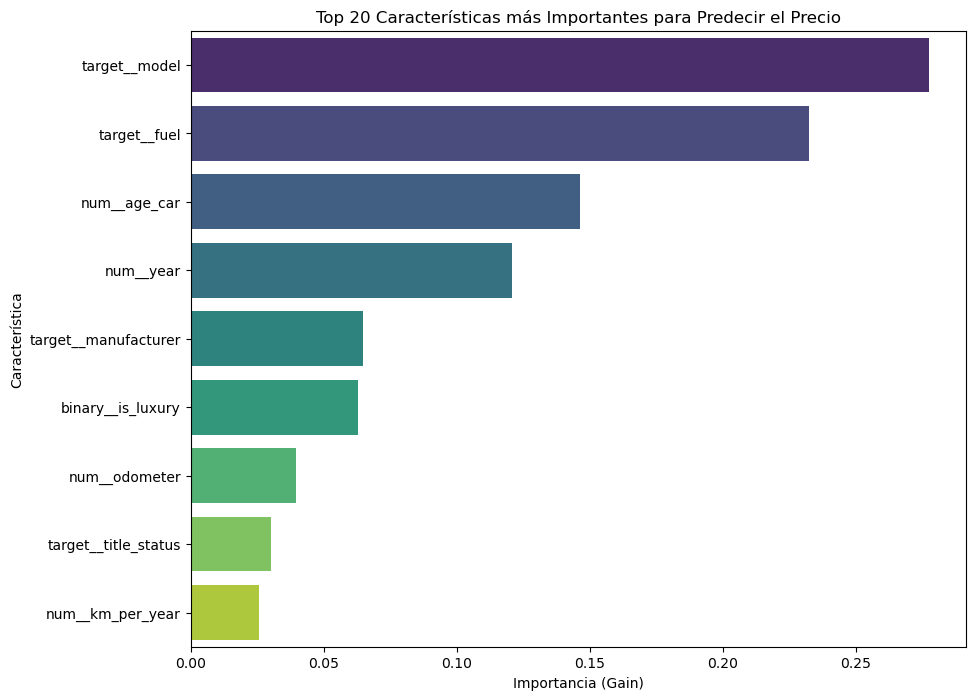

                Feature  Importance
7         target__model    0.277527
4          target__fuel    0.232515
2          num__age_car    0.146283
0             num__year    0.120713
6  target__manufacturer    0.064865
8     binary__is_luxury    0.062831
1         num__odometer    0.039614
5  target__title_status    0.030094
3      num__km_per_year    0.025558


In [36]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Características más Importantes para Predecir el Precio')
plt.xlabel('Importancia (Gain)')
plt.ylabel('Característica')
plt.show()

# Ver la tabla completa en texto
print(importance_df)

1rts try

    Feature  Importance
4          cat__fuel    0.287343
2       num__age_car    0.216253
0          num__year    0.163464
7         cat__model    0.111567
6  cat__manufacturer    0.095708
1      num__odometer    0.045279
5  cat__title_status    0.038598
3   num__km_per_year    0.025590
8       cat__odo_cat    0.016199


2try
4262.564453125 mse